In [1]:
import jax
import numpy as np
import numba as nb
from jax import jit
from tqdm import tqdm
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from typing import Dict, List, Tuple, Union
from matplotlib.animation import FuncAnimation
from jax.experimental.ode import odeint as jaxode
from concurrent.futures import ProcessPoolExecutor, as_completed


# The Lorentz system overview

Defining the system

Consider $x = (x, y,z)$:

$$ 
\begin{gather*}
\dot{x} = \sigma(y - x)\\ 
\dot{y} = x(\rho - z) - y \\ 
\dot{z} = xy - \beta z
\end{gather*}
$$

the Lorenz system, which has long been used for studying the interplay between predictability and chaos. We select with $\beta = 8/3$ and $\sigma = 10$ standard parameter settings, retaining $\rho$ as the bifurcation parameter.

![](lorenz_attractor.gif)

In [2]:
@jit
def lorenz_system_jx(state: jnp.ndarray, t: float, r: float, sigma: float = 10.0, beta: float = 8.0/3.0) -> jnp.ndarray:
    """
    Lorenz system derivatives.
    """
    x, y, z = state
    x_dot = sigma * (y - x)
    y_dot = (r - z) * x - y
    z_dot = x * y - beta * z
    return jnp.array([x_dot, y_dot, z_dot], dtype=state.dtype)  # Match dtype to input

def solve_lorenz_jax(r_values: jnp.ndarray, t_span: tuple, dt: float, initial_state: jnp.ndarray, save_trajectories: bool = False) -> dict:
    """
    Solve the Lorenz system for a range of r values using JAX.
    """
    t = jnp.arange(t_span[0], t_span[1], dt, dtype=jnp.float32)  # Ensure consistent dtype
    trajectories = []
    r_maxes, z_maxes, r_mins, z_mins = [], [], [], []

    state = initial_state.astype(jnp.float32)  # Ensure consistent dtype

    for r in tqdm(r_values):
        r = jnp.float32(r)  # Cast r to float32
        # Solve the ODE for the current r
        trajectory = jaxode(lorenz_system_jx, state, t, r)
        if save_trajectories:
            trajectories.append(trajectory)

        # Analyze the trajectory for maxima, minima, etc.
        z_vals = trajectory[:, 2]
        maxima_indices = (z_vals[1:-1] > z_vals[:-2]) & (z_vals[1:-1] > z_vals[2:])
        minima_indices = (z_vals[1:-1] < z_vals[:-2]) & (z_vals[1:-1] < z_vals[2:])

        maxima_indices = jnp.where(maxima_indices)[0] + 1
        minima_indices = jnp.where(minima_indices)[0] + 1

        r_maxes.extend([r.item()] * len(maxima_indices))
        z_maxes.extend(z_vals[maxima_indices])
        r_mins.extend([r.item()] * len(minima_indices))
        z_mins.extend(z_vals[minima_indices])

        # Update initial state for the next r
        state = trajectory[-1]

    results = {
        "r_values": r_values,
        "r_maxes": r_maxes,
        "z_maxes": z_maxes,
        "r_mins": r_mins,
        "z_mins": z_mins,
    }

    if save_trajectories:
        results["trajectories"] = trajectories

    return results


In [3]:
with jax.default_device(jax.devices("cpu")[0]):
    # Parameters
    dr = 0.001
    r_values = jnp.arange(180, 183, dr, dtype=jnp.float32)  # Ensure consistent dtype
    dt = 0.001
    t_span = (0, 50)
    initial_state = jnp.array([1, 1, 1], dtype=jnp.float32)  # Ensure consistent dtype

    # Solve the system
    results = solve_lorenz_jax(r_values, t_span, dt, initial_state)


100%|██████████| 3000/3000 [02:30<00:00, 19.90it/s]


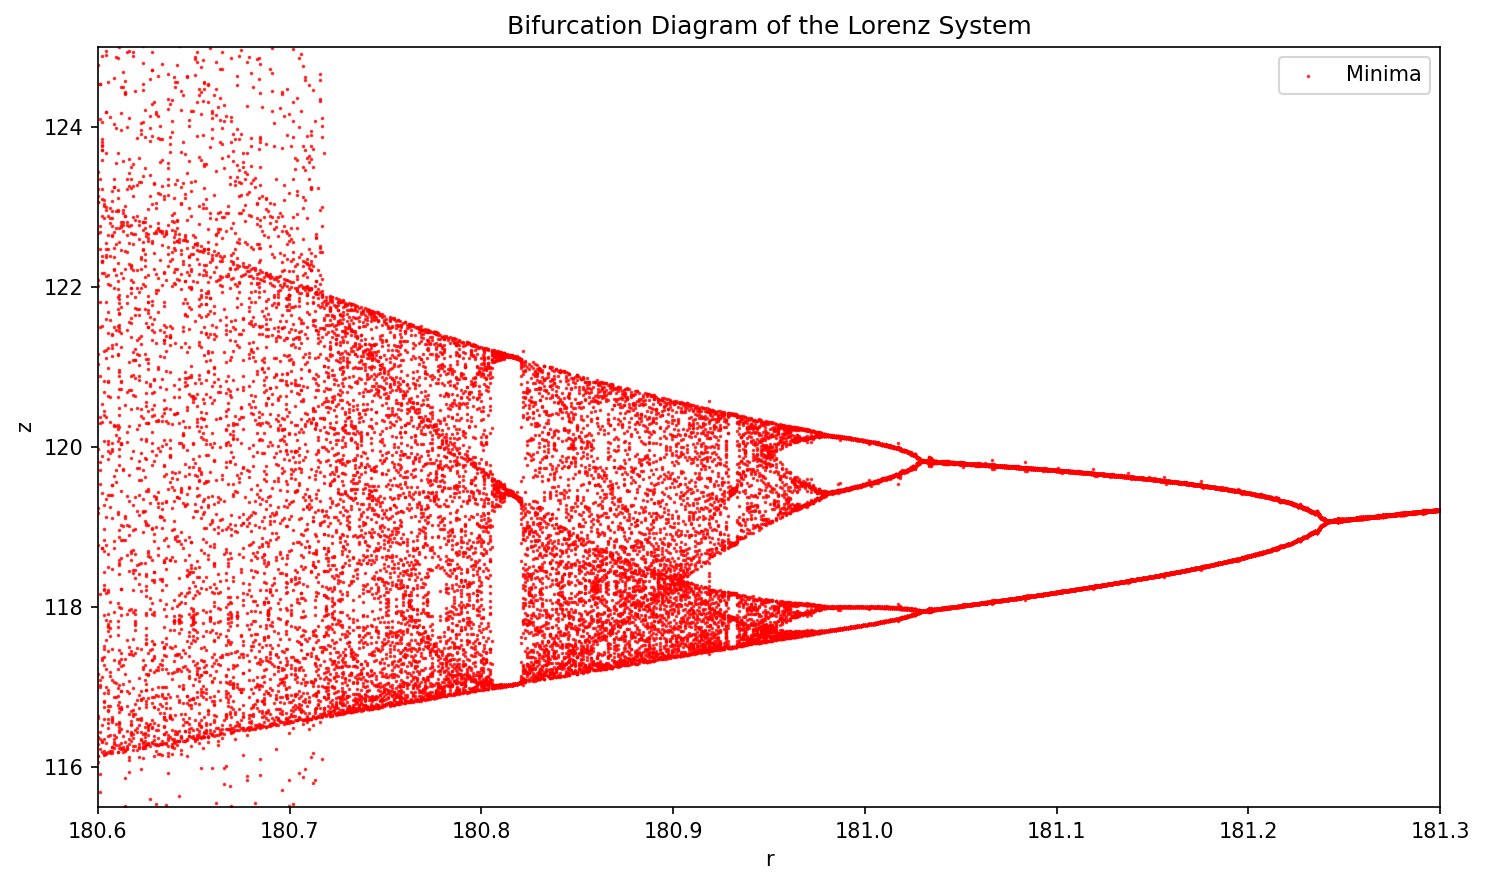

In [9]:

# Plot the results
plt.figure(figsize=(10, 6), dpi=150)
# plt.scatter(results['r_maxes'], results['z_maxes'], color='blue', s=0.5, label='Maxima', alpha = 0.25)
plt.scatter(results['r_mins'], results['z_mins'], color='red', s=0.5, label='Minima', alpha = 0.75)
# plt.scatter(results['r_s'], results['z_s'], color='black', s=0.5, label='x=15', alpha = 0.25)
plt.xlabel('r')
plt.ylabel('z')
plt.title('Bifurcation Diagram of the Lorenz System')
plt.legend()
plt.xlim(180.6, 181.3)
plt.ylim(115.5,125)
plt.tight_layout()
# plt.savefig("../figs/bif_diagram3.png", dpi = 150)
plt.show()

In [13]:
import torch
from torchdiffeq import odeint  # Install with: pip install torchdiffeq
from tqdm import tqdm

def lorenz_system(state: torch.Tensor, t: torch.Tensor, r: torch.Tensor, sigma: float = 10.0, beta: float = 8.0 / 3.0) -> torch.Tensor:
    """
    Compute the derivatives of the Lorenz system at a given state.
    """
    x, y, z = state[..., 0], state[..., 1], state[..., 2]
    x_dot = sigma * (y - x)
    y_dot = (r - z) * x - y
    z_dot = x * y - beta * z
    return torch.stack([x_dot, y_dot, z_dot], dim=-1)

def solve_lorenz_torch(
    r_values: torch.Tensor,
    t_span: tuple,
    dt: float,
    initial_state: torch.Tensor,
    device: str = "cpu",
    save_trajectories: bool = False
) -> dict:
    """
    Solve the Lorenz system for a range of r values using PyTorch.
    """
    t = torch.arange(t_span[0], t_span[1], dt, device=device)
    trajectories = []
    r_maxes, z_maxes, r_mins, z_mins = [], [], [], []

    # Ensure initial state has a batch dimension
    state = initial_state.to(device)  # Shape: (batch, 3)
    r_values = r_values.to(device)

    for r in tqdm(r_values):
        def lorenz_with_r(s, time):
            return lorenz_system(s, time, r.unsqueeze(0))

        # Solve the ODE for the current r
        trajectory = odeint(lorenz_with_r, state, t, method='rk4')  # Shape: (T, batch, 3)
        trajectory = trajectory.squeeze(1)  # Remove batch dimension for analysis
        if save_trajectories:
            trajectories.append(trajectory)

        # Analyze the trajectory
        z_vals = trajectory[:, 2]
        maxima_indices = (z_vals[1:-1] > z_vals[:-2]) & (z_vals[1:-1] > z_vals[2:])
        minima_indices = (z_vals[1:-1] < z_vals[:-2]) & (z_vals[1:-1] < z_vals[2:])

        maxima_indices = torch.where(maxima_indices)
        minima_indices = torch.where(minima_indices)

        r_maxes.extend([r.item()] * len(maxima_indices[0]))
        z_maxes.extend(z_vals[maxima_indices].cpu().tolist())
        r_mins.extend([r.item()] * len(minima_indices[0]))
        z_mins.extend(z_vals[minima_indices].cpu().tolist())

        # Update the initial state for the next r
        state = trajectory[-1].unsqueeze(0)  # Keep batch dimension

    results = {
        "r_values": r_values.cpu(),
        "r_maxes": r_maxes,
        "z_maxes": z_maxes,
        "r_mins": r_mins,
        "z_mins": z_mins,
    }

    if save_trajectories:
        results["trajectories"] = trajectories

    return results

In [14]:
def generate_pairs_of_initial_states_torch(n_pairs: int, distance: float, device: str = "cpu") -> tuple:
    """
    Generate pairs of initial states for the Lorenz system.

    Parameters:
        n_pairs (int): Number of pairs to generate.
        distance (float): Distance between the pairs.
        device (str): Device to use ('cpu' or 'cuda').

    Returns:
        tuple: Two tensors of initial states.
    """
    initial_conditions_1 = torch.rand((n_pairs, 3), device=device)
    direction = torch.randn((n_pairs, 3), device=device)
    direction = direction / torch.norm(direction, dim=1, keepdim=True)
    initial_conditions_2 = initial_conditions_1 + direction * distance
    return initial_conditions_1, initial_conditions_2


In [16]:
initial_state = torch.tensor([[1.0, 1.0, 1.0]], device=device)  # Batch of 1


In [18]:
torch.stack([1,2,3], dim=-1)

TypeError: expected Tensor as element 0 in argument 0, but got int

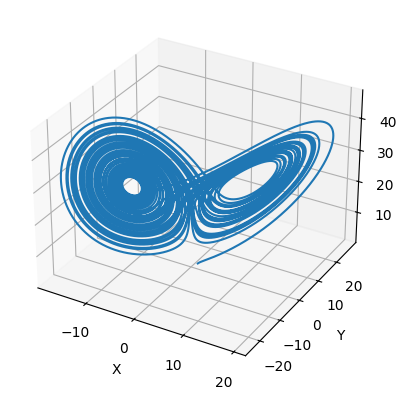

In [28]:
import torch

def lorenz_system(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Defines the Lorenz system of differential equations.
    
    Args:
        state: Tensor of shape (3,) representing [x, y, z].
        t: Time (not used as Lorenz is autonomous but included for compatibility with solvers).
        sigma, rho, beta: Parameters of the Lorenz system.

    Returns:
        Tensor of shape (3,) representing the time derivatives [dx/dt, dy/dt, dz/dt].
    """
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return torch.tensor([dxdt, dydt, dzdt])

def rk4_step(func, state, t, dt, *args):
    """
    Performs a single step of the Runge-Kutta 4th order (RK4) method.
    
    Args:
        func: Function defining the system of ODEs.
        state: Current state as a tensor.
        t: Current time.
        dt: Time step size.
        *args: Additional arguments for the system function.

    Returns:
        Tensor representing the next state.
    """
    k1 = func(state, t, *args)
    k2 = func(state + 0.5 * dt * k1, t + 0.5 * dt, *args)
    k3 = func(state + 0.5 * dt * k2, t + 0.5 * dt, *args)
    k4 = func(state + dt * k3, t + dt, *args)
    return state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def solve_lorenz(initial_state, t_span, dt, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Solves the Lorenz system using the RK4 method.
    
    Args:
        initial_state: Tensor of shape (3,) representing the initial [x, y, z].
        t_span: Tuple (t_start, t_end) representing the time range.
        dt: Time step size.
        sigma, rho, beta: Parameters of the Lorenz system.

    Returns:
        Tensor of shape (num_steps, 3) with the solution at each time step.
    """
    t_start, t_end = t_span
    num_steps = int((t_end - t_start) / dt) + 1
    states = torch.zeros((num_steps, 3))
    states[0] = initial_state

    t = t_start
    for i in range(1, num_steps):
        states[i] = rk4_step(lorenz_system, states[i-1], t, dt, sigma, rho, beta)
        t += dt

    return states

# Example usage
if __name__ == "__main__":
    initial_state = torch.tensor([1.0, 1.0, 1.0])
    t_span = (0.0, 50.0)
    dt = 0.001

    trajectory = solve_lorenz(initial_state, t_span, dt)

    # Plot the results (requires matplotlib)
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:, 0].numpy(), trajectory[:, 1].numpy(), trajectory[:, 2].numpy())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


In [4]:
def simulate_lorenz_with_warmup(
    rho,
    sigma,
    beta,
    t_span,
    t_eval,
    warmup_t = 20,
    perturbation = 1e-8,
    analysis_step = 2000,
    delta_t = 1e-3,
    poincare_x = 15,
    lyap_trials = 100
):
    """
    Simulates the Lorenz system, calculates Lyapunov exponent, cross-distance scaling exponent ν, 
    cross-correlation, and Poincaré map intersections.

    Parameters:
    ----------
    rho : float
        Bifurcation parameter.
    sigma : float
        Lorenz parameter σ.
    beta : float
        Lorenz parameter β.
    t_span : tuple
        Total time span for the simulation.
    t_eval : np.ndarray
        Time points for evaluation.
    warmup_t : int, optional
        Number of steps for warming up the system (default is 5000).
    perturbation : float, optional
        Perturbation to create a nearby trajectory (default is 1e-8).
    analysis_step : int, optional
        Number of steps for Lyapunov exponent fitting (default is 2000).
    poincare_x : float, optional
        X-plane value for Poincaré map intersections (default is 15).

    Returns:
    -------
    results : dict
        A dictionary containing:
        - 'rho': The bifurcation parameter value.
        - 'lyapunov_exponent': The computed Lyapunov exponent λ.
        - 'cross_corr': Cross-correlation C12.
        - 'scaling_exponent': Cross-distance scaling exponent ν.
        - 'poincare_map': List of (y, z) coordinates at Poincaré intersections.
        - 'distance_trajectory': Norm of differences over time.
    """

    # Step 1: Warmup the system
    if warmup_t > 0:
        initial_state = [1.0, 1.0, 1.0]
        warmup_eval = np.arange(0.0, warmup_t, delta_t)
        warmup_sol = solve_ivp(lorenz_system, (0, warmup_t), initial_state, args=(sigma, rho, beta), t_eval=warmup_eval, method='RK45')
        warmup_state = warmup_sol.y[:, -1]  # Final state after warmup
    else:
        warmup_state = [1.0, 1.0, 1.0]

    analysis_eval = np.linspace(0, t_span[1], len(t_eval))
    sol_original = solve_ivp(lorenz_system, t_span, warmup_state, args=(sigma, rho, beta), t_eval=analysis_eval, method='RK45')
    
    # Step 2: Create a perturbed state
    trajectories_for_lyap = []
    for i in range(lyap_trials):
        random_vector = np.random.uniform(-1, 1, size=warmup_state.shape)
        random_vector /= np.linalg.norm(random_vector)
        perturbed_state = warmup_state + perturbation * random_vector

        # Step 3: Evolve both trajectories
        
        sol_perturbed = solve_ivp(lorenz_system, t_span, perturbed_state, args=(sigma, rho, beta), t_eval=analysis_eval, method='RK45')
        trajectories_for_lyap.append(sol_perturbed.y.T)

    trajectories_for_lyap = np.array(trajectories_for_lyap) 
    # Step 4: Compute norm of differences
    distance_trajectory = np.mean(np.linalg.norm(trajectories_for_lyap - sol_original.y.T, axis=0), axis=1)
    # Step 5: Fit Lyapunov exponent
    log_distances = np.log(distance_trajectory)
    lyap_fit = np.polyfit(analysis_eval, log_distances, 1)
    lyapunov_exponent = lyap_fit[0]  # Slope gives λ_max

    nu, _ = np.polyfit(np.log(analysis_eval[analysis_step:]), np.log(distance_trajectory[analysis_step:]), 1)

    #print("Lyapunov ready")

    # Step 6: Compute cross-correlation
    x1 = sol_original.y
    mu = np.mean(x1.T, axis = 0)
    s2 = np.sum(np.mean((x1.T - mu)**2, axis=0))
    
    cross_corr = np.mean(np.sum((x1.T - mu)[None, :, :] * (trajectories_for_lyap - mu), axis = -1), axis=0) / s2
    poincare_map = []
    for i in range(1, sol_original.y.shape[1]):
        if sol_original.y[0, i - 1] < poincare_x <= sol_original.y[0, i]:  # Crossing the plane x = poincare_x
            # Linear interpolation for more accurate intersection
            t1, t2 = sol_original.t[i - 1], sol_original.t[i]
            x1, x2 = sol_original.y[0, i - 1], sol_original.y[0, i]
            y1, y2 = sol_original.y[1, i - 1], sol_original.y[1, i]
            z1, z2 = sol_original.y[2, i - 1], sol_original.y[2, i]
            alpha = (poincare_x - x1) / (x2 - x1)
            y_poincare = y1 + alpha * (y2 - y1)
            z_poincare = z1 + alpha * (z2 - z1)
            poincare_map.append((y_poincare, z_poincare))

    #print("Poincare ready")

    # Return all results
    return {
        "rho": rho,
        "traj1": sol_original.y,
        "scaling_exponent": nu,
        "cross_corr": cross_corr,
        "poincare_map": poincare_map,
        "warmup_state": warmup_state,
        "lyapunov_exponent": lyapunov_exponent,
        "distance_trajectory": distance_trajectory,
    }

In [5]:
# Parameters
sigma = 10
beta = 8 / 3
# rho_values = np.linspace(180.5, 181.3, 100)
rho_values = np.linspace(180.6, 181.3, 100)
t_span = (0, 50)
dt = 1e-3
t_eval = np.arange(0.0, t_span[1], dt)
deltas = np.logspace(-9, -6, 4)


In [6]:
# Parallel execution
results = []

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(simulate_lorenz_with_warmup, rho, sigma, beta, t_span, t_eval): rho for rho in rho_values}

    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# Sort results by rho
results.sort(key=lambda x: x["rho"])

100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


In [20]:
results[0]['traj1'][0]

array([ -4.4382958 , -38.33081499,   2.408286  , ..., -41.3967749 ,
        29.68967471,   1.13479625])

In [63]:
(sigma, rho_values[-1], beta)

(10, 181.2, 2.6666666666666665)

In [8]:
def get_poincare_section(trajectory, t_eval, dimension, value, direction='both'):
    """
    Extract the Poincaré section of a trajectory at a specific value on a given dimension.
    
    Parameters:
    -----------
    trajectory : np.ndarray
        The trajectory as a 2D array of shape (time steps, dimensions).
    t_eval : np.ndarray
        The time points corresponding to the trajectory.
    dimension : int
        The dimension index to fix (0 for x, 1 for y, 2 for z, etc.).
    value : float
        The value at which to take the Poincaré section.
    direction : str, optional
        'both', 'positive', or 'negative' to specify the crossing direction:
        - 'both': Crossings in any direction.
        - 'positive': Only consider crossings where the trajectory enters from below.
        - 'negative': Only consider crossings where the trajectory enters from above.
    
    Returns:
    --------
    poincare_points : np.ndarray
        Points in the Poincaré section as a 2D array of shape (num_points, dimensions).
    crossing_times : np.ndarray
        The corresponding times of the crossings.
    """
    trajectory = np.asarray(trajectory)
    t_eval = np.asarray(t_eval)

    # Extract the dimension of interest
    dim_values = trajectory[:, dimension]
    
    # Identify crossings of the specified value
    if direction == 'both':
        crossings = np.where((dim_values[:-1] - value) * (dim_values[1:] - value) < 0)[0]
    elif direction == 'positive':
        crossings = np.where((dim_values[:-1] - value < 0) & (dim_values[1:] - value > 0))[0]
    elif direction == 'negative':
        crossings = np.where((dim_values[:-1] - value > 0) & (dim_values[1:] - value < 0))[0]
    else:
        raise ValueError("Invalid direction. Use 'both', 'positive', or 'negative'.")

    # Linear interpolation to find exact crossing points
    poincare_points = []
    crossing_times = []

    for i in crossings:
        t1, t2 = t_eval[i], t_eval[i + 1]
        x1, x2 = trajectory[i], trajectory[i + 1]
        d1, d2 = dim_values[i] - value, dim_values[i + 1] - value

        # Interpolate in time and space
        t_cross = t1 - d1 * (t2 - t1) / (d2 - d1)
        x_cross = x1 + (x2 - x1) * (-d1) / (d2 - d1)

        poincare_points.append(x_cross)
        crossing_times.append(t_cross)

    return np.array(poincare_points), np.array(crossing_times)


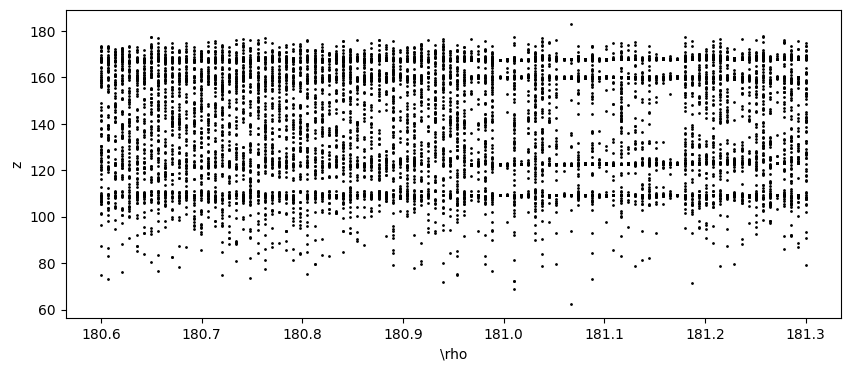

In [13]:
# Get Poincaré section
dimension = 0  # z-dimension
value = 15.0  # Fixed value for the Poincaré section
direction = 'positive'  # Consider crossings in the positive direction

all_poincare_points = []
for result in results:

    poincare_points, crossing_times = get_poincare_section(result['traj1'].T, t_eval, dimension, value, direction)
    all_poincare_points.append(poincare_points)

fig, ax = plt.subplots(figsize=(10, 4))

for i, pp in enumerate(all_poincare_points):
    ax.scatter(rho_values[i]*np.ones(pp.shape[0]), pp[:,2], s = 1, c= 'k')
ax.set_xlabel(r'\rho')
ax.set_ylabel('z')
plt.show()

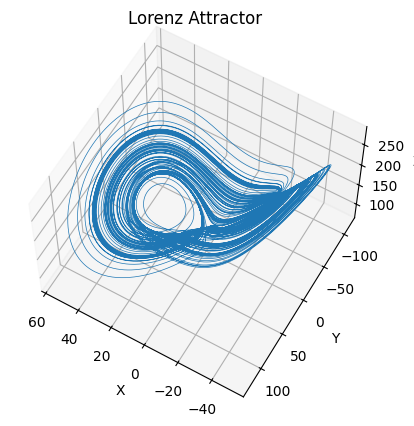

In [15]:
results[0]["traj1"]
ax = plt.figure().add_subplot(projection='3d')
ax.view_init(elev=60, azim=120, roll=0)

ax.plot(*results[0]["traj1"], lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor")
plt.show()

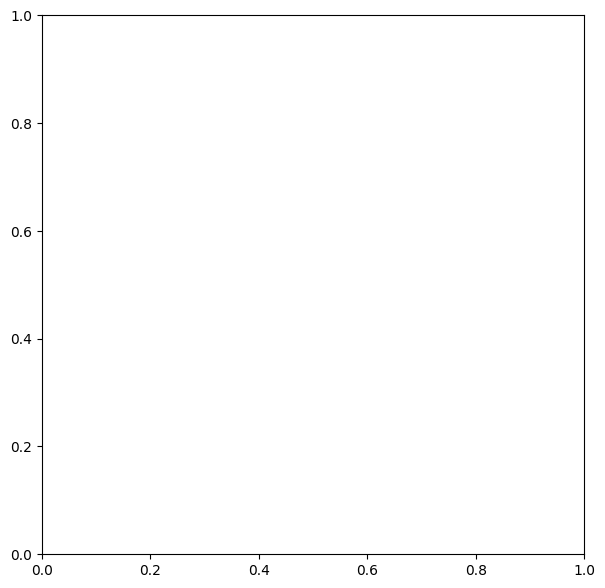

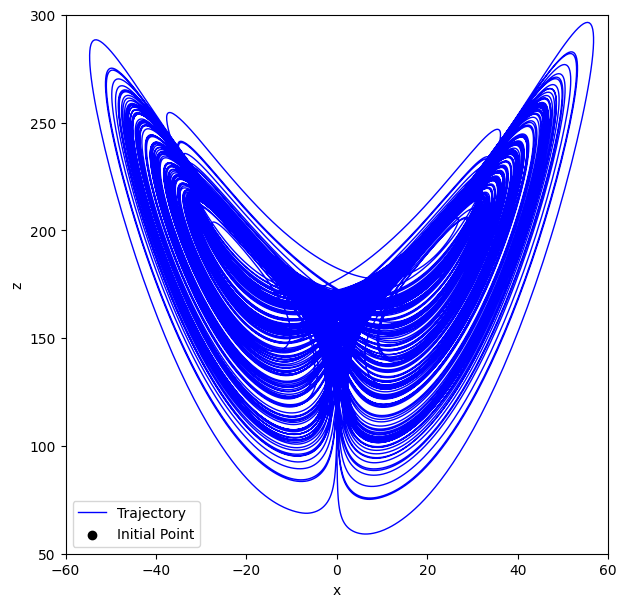

In [135]:
fig, ax = plt.subplots(figsize=(7, 7))
from_when = 85000
# ax.plot(results[0]["traj1"][0][-from_when:], results[0]["traj1"][2][-from_when:],lw=1.0,color="blue",label="Trajectory")
# ax.scatter(results[0]["traj1"][0][-from_when],results[0]["traj1"][2][-from_when],color="black",label="Initial Point")

# ax.set_xlabel("x")
# ax.set_ylabel("z")
# ax.set_xlim(-60,60)
# ax.set_ylim(50,300)
# plt.legend()

# (sigma, rho, beta)
sol = solve_ivp(lorenz_system, t_span, [1.0, 1.0, 1.0], args=(sigma, 180.7, beta), t_eval=t_eval, method='RK45')

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(sol.y[0][-from_when:], sol.y[2][-from_when:], lw=1.0,color="blue",label="Trajectory")
ax.scatter(sol.y[0][-from_when],sol.y[2][-from_when],color="black",label="Initial Point")

ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_xlim(-60,60)
ax.set_ylim(50,300)
plt.legend()

In [24]:
# Compute maximal Lyapunov exponent λ_max
d = np.linalg.norm(trajectories1[0] - trajectories2[0], axis=0)
log_distances = np.log(d/(d[1]+1e-15))  # Skip initial zero distance
times = t_eval  # Corresponding times
valid_idx = t_eval > 200
lyap_fit = np.polyfit(times[valid_idx], log_distances[valid_idx], 1)
lyapunov_exponent = lyap_fit[0]  # Slope gives λ_max

In [26]:
lyap_fit

array([-6.83870772e-04,  1.38339015e+01])

In [11]:

# Sort results by rho to maintain order
results.sort(key=lambda x: x[0])
rho_values, trajectories1, trajectories2, cross_correlations, cross_dist_exp = zip(*results)


In [17]:
trajectories1[0][0].shape

(10000,)

In [23]:
cross_correlations[0].shape

(40000,)

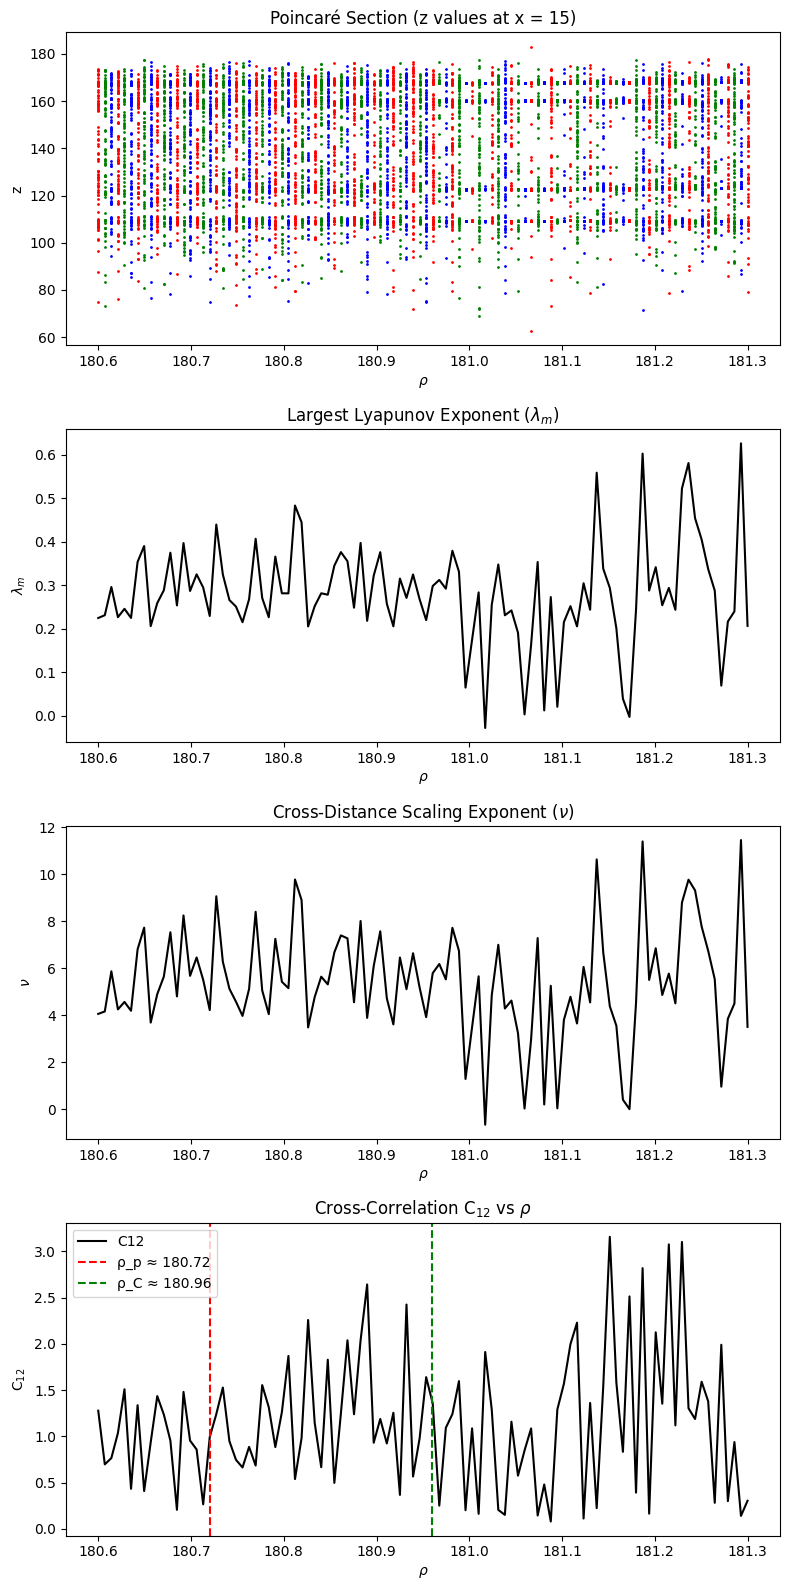

In [7]:
# Prepare data from results
rho_values = [result["rho"] for result in results]
lyapunov_exponents = [result["lyapunov_exponent"] for result in results]
scaling_exponents = [result["scaling_exponent"] for result in results]
cross_correlations = [result["cross_corr"] for result in results]
poincare_maps = [result["poincare_map"] for result in results]

# Colors for the phases
colors = ["red", "green", "blue"]  # Strong chaos, partially predictable chaos, regular flow

# Generate plots
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

# Plot Poincaré section
for i, (rho, poincare_map) in enumerate(zip(rho_values, poincare_maps)):
    poincare_map = np.array(poincare_map)
    z_vals = poincare_map[:, 1]  # Extract z-coordinates at x = 15
    axs[0].scatter([rho] * len(z_vals), z_vals, color=colors[i % len(colors)], s=1)
axs[0].set_title("Poincaré Section (z values at x = 15)")
axs[0].set_xlabel(r"$\rho$")
axs[0].set_ylabel("z")

# Plot Lyapunov exponent
axs[1].plot(rho_values, lyapunov_exponents, label=r"$\lambda_m$", color="black")
axs[1].set_title(r"Largest Lyapunov Exponent ($\lambda_m$)")
axs[1].set_xlabel(r"$\rho$")
axs[1].set_ylabel(r"$\lambda_m$")

# Plot cross-distance scaling exponent (ν)
axs[2].plot(rho_values, scaling_exponents, label=r"$\nu$", color="black")
axs[2].set_title(r"Cross-Distance Scaling Exponent ($\nu$)")
axs[2].set_xlabel(r"$\rho$")
axs[2].set_ylabel(r"$\nu$")

# Plot cross-correlation (C)
axs[3].plot(rho_values, np.array(cross_correlations)[:,20], label="C12", color="black")
axs[3].axvline(x=180.72, color="red", linestyle="--", label="ρ_p ≈ 180.72")
axs[3].axvline(x=180.96, color="green", linestyle="--", label="ρ_C ≈ 180.96")
axs[3].set_title(r"Cross-Correlation C$_{12}$ vs $\rho$")
axs[3].set_xlabel(r"$\rho$")
axs[3].set_ylabel(r"C$_{12}$")
axs[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()
